In [1]:
import sys
import os
sys.path.append('../')
sys.path.append('../modules/')
sys.path.append('../util/')


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import random
import models_Segmentation
from modeling.deeplab import *
from modeling.Unet_models import *
from util.metrics import *

## data visualization

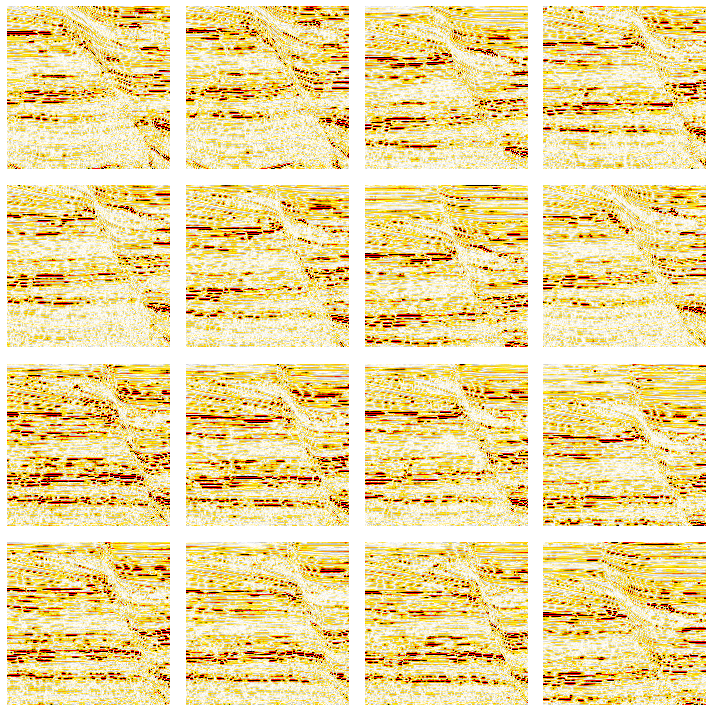

In [2]:
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)


data_path = '../../Data/Facies/' +'seismic/'
label_path = '../../Data/Facies/' +'label/'
data_files =  [str(f)+'.dat' for f in range(100,117)]
selected_files = random.sample(data_files, 16) # Random Select files to show


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(data_path, selected_files[i]), 'rb') as f:
        
        data = np.fromfile(f, dtype=np.single)
        data = data.reshape((768, 768))
        ax.imshow(data, cmap=cmap,vmin=np.min(data)/10,vmax=-np.min(data)/10)
        ax.axis('off')
# 显示整个图像
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

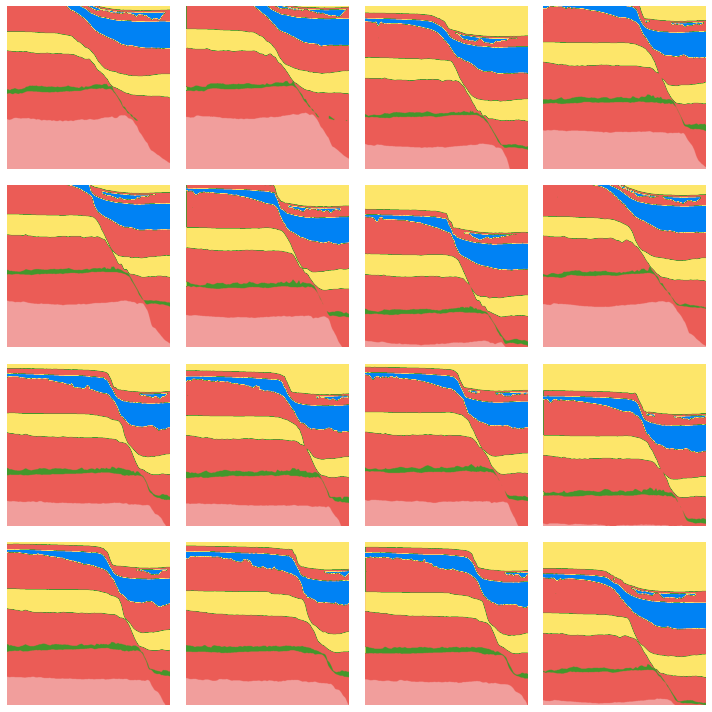

In [3]:
color_list = ['#F19E9C','#EB5C56','#43972B','#FEE76B','#F3B677','#0082F4'] #seam
cmapl = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(label_path, selected_files[i]), 'rb') as f:
        data = np.fromfile(f, dtype=np.single)-1
        data = data.reshape((768, 768))
        ax.imshow(data, cmap=cmapl)#,vmin=np.min(data)/2,vmax=-np.min(data)/2)
        ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Define utils

In [4]:
import matplotlib as mpl
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

def show_image(image, vmin=None, vmax=None, title='', figsize=None,cmap=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(image, cmap=cmap, interpolation='bicubic', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(image, interpolation='bicubic', vmin=vmin, vmax=vmax)
    plt.title(title)
#     plt.axis('off')
    # plt.show()
    return

## load Model

In [5]:
def prepare_model(chkpt_dir, arch='vit_large_patch16', img_size=768):
    model = getattr(models_Segmentation, arch)(num_classes=6, 
                                      drop_path_rate=0.1, 
                                      in_chans=1, 
                                      img_size=img_size,
                                      global_pool=False,
                                      )
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
#     interpolate_pos_embed(model, checkpoint['model'])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model 

In [6]:
#SFM-Fine-tune
chkpt_dir = './Facies/SFM-Finetune/checkpoint-99.pth' 
model_SFM = prepare_model(chkpt_dir, 'vit_base_patch16', img_size=768)

<All keys matched successfully>


In [7]:
def run_one_image(img, model,l):
    x = torch.tensor(img)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    model_SFM.eval()
    pred = model_SFM(x)
    pred = pred.argmax(dim=1).detach().cpu()
    pred = pred.squeeze(0)
    pred = pred.squeeze(0)
    
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.subplot(1,3, 1)
    show_image(img, vmin=x.min()/12, vmax=x.max()/12, title="Seismic",cmap=cmap)
    
    plt.subplot(1,3, 2)
    show_image(l,cmap=cmapl, title="Label")
    
    plt.subplot(1,3, 3)
    show_image(pred,cmap=cmapl, title="SFM-Finetune Prediction")

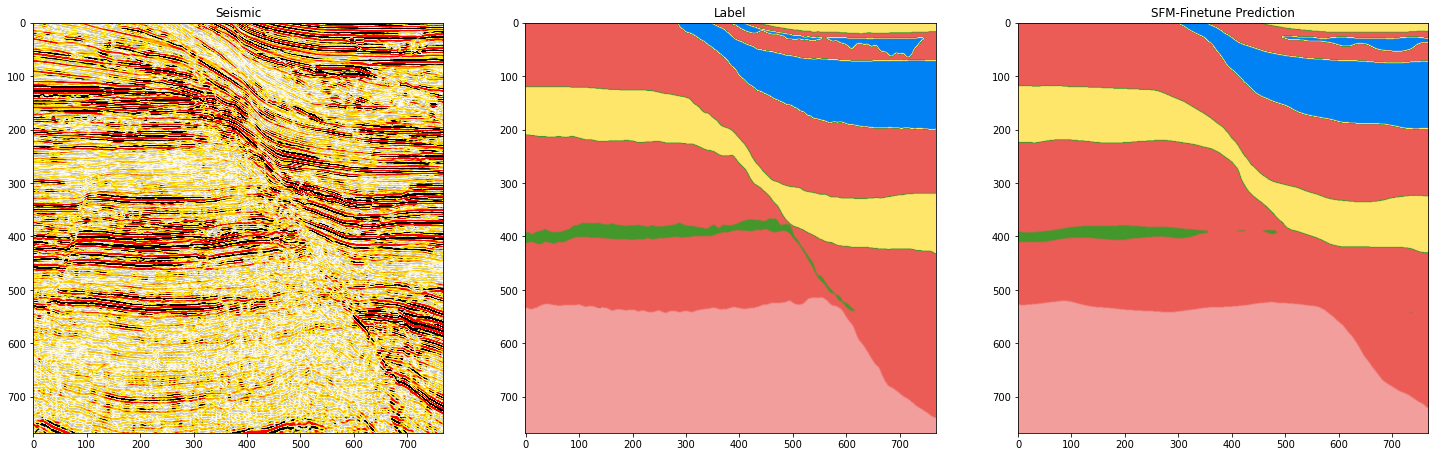

In [8]:
data_list = ['../../Data/Facies/' +'seismic/'+ str(f)+'.dat' for f in range(117)]
label_list = [f.replace('/seismic/', '/label/') for f in data_list]
dnum = 100
d = np.fromfile(data_list[dnum], np.float32)
d = d.reshape((768,768))
l = np.fromfile(label_list[dnum], np.float32).reshape([768,768])-1
l = l.astype(int)
run_one_image(d, model_SFM,l)

### Run index

In [9]:
def run_index(img, model, label=None, clims=None, savefig=None):
    model.eval()
    
    x = torch.tensor(img, dtype=torch.float32)
    pred  = model(x)
    pred  = pred.argmax(dim=1).detach().cpu()
    print(pred.shape)
    pred = pred.squeeze(0)
    return pred.numpy()

In [10]:
dd = np.zeros((5, 1, 768, 768))
predall = np.zeros((17, 768, 768)).astype('int64')

# loop through data
for j, start_idx in enumerate(range(100, 115, 5)):
    end_idx = start_idx + 5
    for i in range(start_idx, end_idx):
        d = np.fromfile(data_list[i], np.float32)
        d = d.reshape([1] + [768,768])
        dd[i-start_idx] = d
    # run prediction for current batch
    predall[j*5:j*5+5] = run_index(dd, model_SFM)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet

# last batch (only has 2 data samples)
dd = np.zeros((2, 1, 768, 768))
for i in range(115, 117):
    d = np.fromfile(data_list[i], np.float32)
    d = d.reshape([1] + [768,768])
    dd[i-115] = d
predall[15:17] = run_index(dd, model_SFM)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet


torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([2, 768, 768])


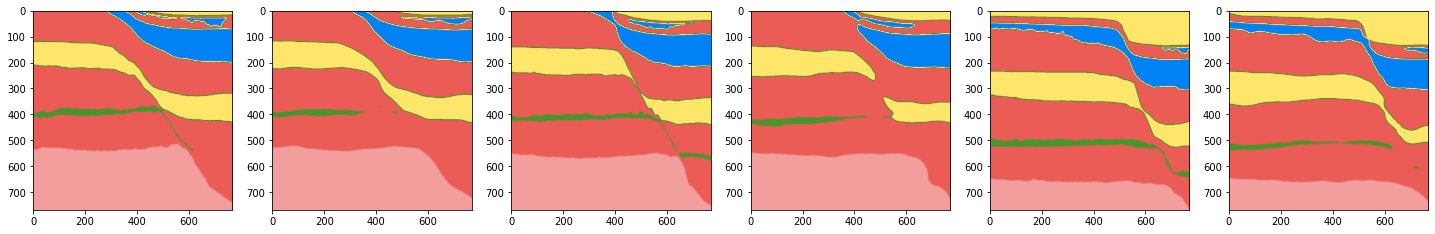

In [11]:
lll = np.zeros((17,768,768)).astype('int32')
for i in range(100,117):
    l = np.fromfile(label_list[i], np.float32).reshape([768,768])-1
    l = l.astype('int32')
    lll[i-100] = l
# predall800 = predall
plt.subplot(1,6,1)
show_image(lll[0],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,2)
show_image(predall[0], cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,3)
show_image(lll[5], cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,4)
show_image(predall[5],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,5)
show_image(lll[15],cmap=cmapl, vmin=0, vmax=5)
plt.subplot(1,6,6)
show_image(predall[15],cmap=cmapl, vmin=0, vmax=5)

In [12]:
pa_base_512,cpa_base_512,mpa_base_512,IoU_base_512,mIoU_base_512 = [],[],[],[],[]
metricall = SegmentationMetric(6)  # 2表示有2个分类，有几个分类就填几
for i in range(17):
    histall = metricall.addBatch(predall[i].astype('int64'), lll[i])
    pa_base_512.append(metricall.pixelAccuracy())
    cpa_base_512.append(metricall.classPixelAccuracy())
    mpa_base_512.append(metricall.meanPixelAccuracy())
    IoU_base_512.append(metricall.IntersectionOverUnion())
    mIoU_base_512.append(metricall.meanIntersectionOverUnion())

../util/metrics.py:30: RuntimeWarning: invalid value encountered in true_divide
  classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
../util/metrics.py:48: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union  # 返回列表，其值为各个类别的IoU


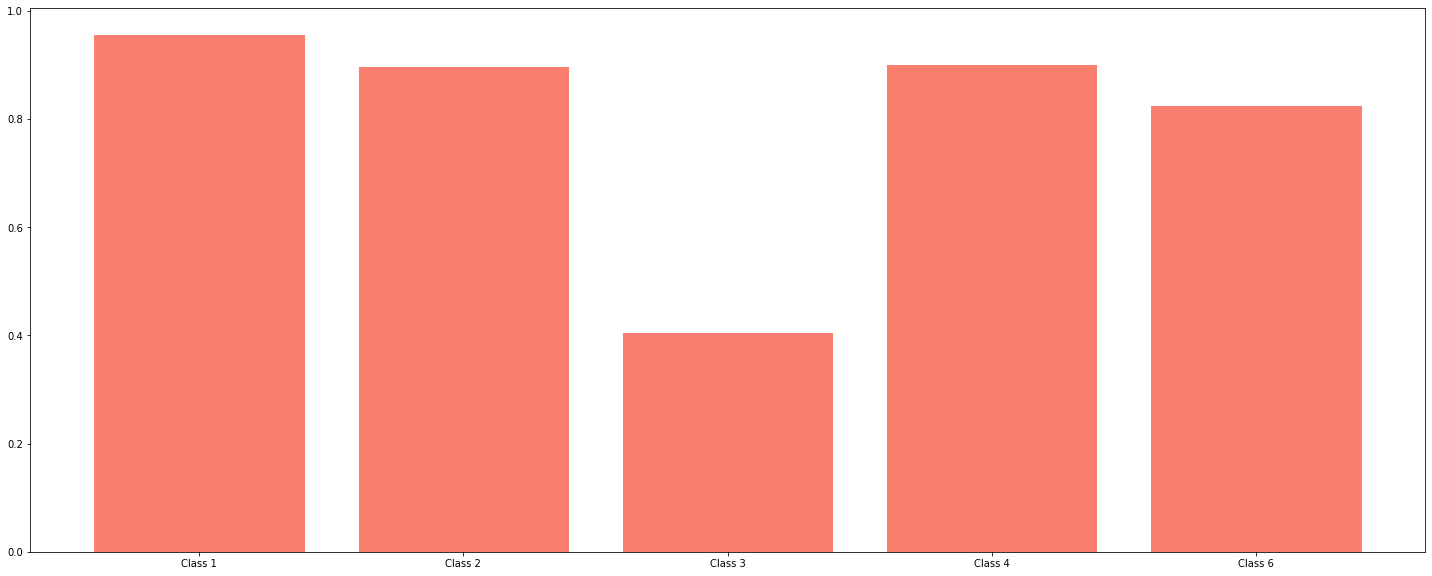

In [13]:
IoU = np.delete(np.mean(IoU_base_512,axis=0),4)
plt.bar(np.arange(5),IoU, color='#FA7F6F', edgecolor='white', label='SFM #512')
plt.xticks(np.arange(5),['Class 1','Class 2','Class 3','Class 4','Class 6'])
plt.show()